# 機械学習入門
##  第4回の演習ノートブック [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isshiki/machine-learning-with-python/blob/main/04_lasso_ridge_regression/04_lasso_ridge_regression.ipynb)

- ＠IT連載： [『Pythonで学ぶ「機械学習」入門【知識ゼロでも大丈夫】』](https://atmarkit.itmedia.co.jp/ait/subtop/features/di/machinelearning_index.html)
- 対応記事： [「「正則化」手法（ラッソ回帰、リッジ回帰）をPythonで学ぼう」](https://atmarkit.itmedia.co.jp/ait/articles/2412/05/news00x.html)

このノートブックは、[Apache License 2.0ライセンス](https://opensource.org/license/apache-2-0)で提供しています。商用でも使用・改変・複製・再配布が可能です。詳細については、LICENSEファイルをご覧ください。

In [1]:
#@title 実行環境のバージョンチェック

# Pythonや各ライブラリのバージョンによって、Pythonコードの挙動が異なる可能性があります。
# そのため、サンプルノートブック作成時の実行環境と一致させられるよう、本連載で提供する全てのサンプルノートブックではバージョン情報を出力しています。

from datetime import datetime
import platform
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import statsmodels

print(f'実行日: {datetime.now():%Y年%m月%d日}')
print(f'Python version: {platform.python_version()}')
print(f'NumPy version: {np.version.version}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

# 実行日: 2024年12月02日
# Python version: 3.10.12
# NumPy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.8.0
# scikit-learn version: 1.5.2

実行日: 2024年12月02日
Python version: 3.10.12
NumPy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.8.0
scikit-learn version: 1.5.2


通常はこのインストール作業は不要です。各ライブラリーのバージョンを、本ノートブック作成時と一致させたい場合は、次のコマンドをコードセルに入力して再インストールしてください。コマンド実行には管理者権限が必要です。

```bash
! pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.0 scikit-learn==1.5.2
```

### ■体験してみよう

scikit-learnには、ラッソ回帰モデルを構築できる`Lasso`クラスと、リッジ回帰モデルを構築できる`Ridge`クラス（いずれも`sklearn.linear_model`モジュール）があります。

#### ●LassoクラスとRidgeクラスの使い方

```python
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso()
ridge_model = Ridge()

lasso_model.fit(＜特徴量：X＞, ＜ターゲット：y＞)
ridge_model.fit(＜特徴量：X＞, ＜ターゲット：y＞)

lasso_model.predict(＜新しいデータ＞)
ridge_model.predict(＜新しいデータ＞)
```

#### ●実際に使ってみよう： データセットの作成

今回は、scikit-learnの`make_regression()`関数を用いて、独自のデータセットを作成します。この関数の詳細な使い方について興味がある場合は、[公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)をご参照ください。


In [3]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 独自のデータセットの作成
data, target, coef = make_regression(
    n_samples=500,
    n_features=6,
    n_informative=4,
    noise=5.0,
    effective_rank=1,
    coef=True,
    random_state=42
)

# 特徴量とターゲットの取得
X = data
y = target

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=0)

print(f'訓練セットのサイズ: {X_train.shape}')  # 訓練セットのサイズ: (450, 6)
print(f'テストセットのサイズ: {X_test.shape}')  # テストセットのサイズ: (50, 6)

訓練セットのサイズ: (450, 6)
テストセットのサイズ: (50, 6)


<a name="corr"></a>

##### ○相関行列を用いて多重共線性を検出

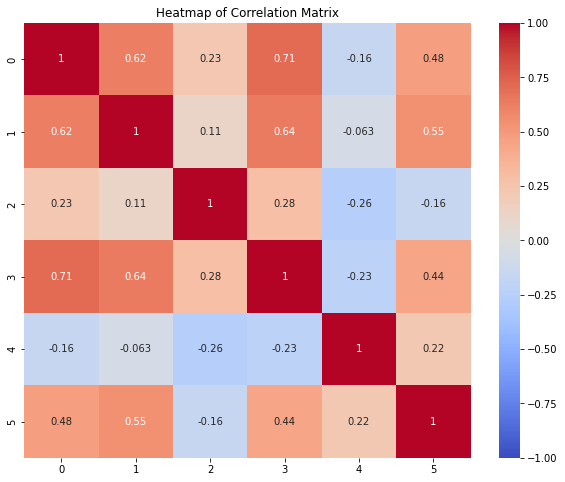

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練セットをpandas DataFrame化
X = pd.DataFrame(X_train)

# 相関行列の計算
corr_matrix = X.corr()

# 相関行列のヒートマップ図の表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
# リスト2のコードの後に以下を記述する

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 訓練セットをpandas DataFrame化
X = pd.DataFrame(X_train)

# VIFの計算
vif_data = pd.DataFrame()
vif_data['Feature'] = housing.feature_names
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を評価
print(vif_data)
#       Feature       VIF
# 0      MedInc  2.506234
# 1    HouseAge  1.247925
# 2    AveRooms  8.468261
# 3   AveBedrms  7.117997
# 4  Population  1.141382
# 5    AveOccup  1.007791
# 6    Latitude  9.325308
# 7   Longitude  8.999270

#### ●実際に使ってみよう： 機械学習モデルの訓練

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 線形回帰モデルの訓練
model = LinearRegression()
model.fit(X_train, y_train)

# ラッソ回帰モデルの訓練
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# リッジ回帰モデルの訓練
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# 各回帰モデルの訓練結果
print('線形回帰　の係数：', model.coef_)
print('線形回帰　の切片：', model.intercept_)
print('ラッソ回帰の係数：', lasso_model.coef_)
print('ラッソ回帰の切片：', lasso_model.intercept_)
print('リッジ回帰の係数：', ridge_model.coef_)
print('リッジ回帰の切片：', ridge_model.intercept_)
# 線形回帰　の係数： [ 0.70668791  2.09152861  0.08314619 -0.43764986  0.04130988  0.50725076]
# 線形回帰　の切片： 0.28175285800430316
# ラッソ回帰の係数： [0.         1.52133124 0.         0.         0.         0.        ]
# ラッソ回帰の切片： 0.27009413431729085
# リッジ回帰の係数： [ 0.70492901  2.08256878  0.08236669 -0.42990413  0.04175077  0.50813198]
# リッジ回帰の切片： 0.2815966957329072

線形回帰　の係数： [ 0.70668791  2.09152861  0.08314619 -0.43764986  0.04130988  0.50725076]
線形回帰　の切片： 0.28175285800430316
ラッソ回帰の係数： [ 0.45229236  1.92077636  0.         -0.          0.          0.42095372]
ラッソ回帰の切片： 0.27369871326412315
リッジ回帰の係数： [ 0.70651048  2.09062785  0.08306762 -0.43686975  0.04135445  0.5073397 ]
リッジ回帰の切片： 0.2817371311234415


#### ●実際に使ってみよう： 訓練済みモデルによる予測

In [ ]:
# テストセットを用いて予測
y_pred = model.predict(X_test)
lasso_y_pred = lasso_model.predict(X_test)
ridge_y_pred = ridge_model.predict(X_test)

# 先頭の5行を出力してみる
print(f'実際　のターゲット（先頭5行）:{y_test[:5]}')
print(f'線形回帰　の予測値（先頭5行）:{y_pred[:5]}')
print(f'ラッソ回帰の予測値（先頭5行）:{lasso_y_pred[:5]}')
print(f'リッジ回帰の予測値（先頭5行）:{ridge_y_pred[:5]}')
# 実際　のターゲット（先頭5行）:[ 2.49267059 -1.1910046   8.95822613 -6.57765569  5.81400091]
# 線形回帰　の予測値（先頭5行）:[-0.68789514  3.05812714 -1.09604768 -1.76511904  2.06961138]
# ラッソ回帰の予測値（先頭5行）:[-0.58260455  2.54273534 -1.18052188 -2.66929956  1.98272488]
# リッジ回帰の予測値（先頭5行）:[-0.6873279   3.05669818 -1.09563585 -1.76659866  2.069662  ]

実際　のターゲット（先頭5行）:[ 2.49267059 -1.1910046   8.95822613 -6.57765569  5.81400091]
線形回帰　の予測値（先頭5行）:[-0.68789514  3.05812714 -1.09604768 -1.76511904  2.06961138]
ラッソ回帰の予測値（先頭5行）:[-0.58260455  2.54273534 -1.18052188 -2.66929956  1.98272488]
リッジ回帰の予測値（先頭5行）:[-0.6873279   3.05669818 -1.09563585 -1.76659866  2.069662  ]


#### ●モデルの評価と考察

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error

# R^2スコア（決定係数）の計算
r2 = r2_score(y_test, y_pred)

# MSE（平均二乗誤差）の計算
mse = mean_squared_error(y_test, y_pred)

# RMSE（平均二乗誤差の平方根）の計算
rmse = root_mean_squared_error(y_test, y_pred)

# MAE（平均絶対誤差）の計算
mae = mean_absolute_error(y_test, y_pred)

# モデルの評価
print(f'決定係数（R^2スコア）: {r2:.2f}')  # 決定係数（R^2スコア）: 0.61
print(f'平均二乗誤差（MSE）: {mse:.2f}')  # 平均二乗誤差（MSE）: 0.54
print(f'平均二乗誤差の平方根（RMSE）: {rmse:.2f}')  # 平均二乗誤差の平方根（RMSE）: 0.73
print(f'平均絶対誤差（MAE）: {mae:.2f}')  # 平均絶対誤差（MAE）: 0.53

決定係数（R^2スコア）: 0.61
平均二乗誤差（MSE）: 0.54
平均二乗誤差の平方根（RMSE）: 0.73
平均絶対誤差（MAE）: 0.53


c:\Users\masa-i\.conda\envs\Kaggle\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<a name="rforestreg"></a>

#### 【参考】他の機械学習手法（ランダムフォレスト回帰）を試す

- `from sklearn.linear_model import LinearRegression`を`from sklearn.ensemble import RandomForestRegressor`に書き換えました。
- `LinearRegression`を`RandomForestRegressor`に書き換え、引数に`random_state=42`を指定しました。
- 線形回帰ではないの、係数の`model.coef_`属性と切片の`model.intercept_`の記述を削除しました。

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# データセットの読み込み
housing = fetch_california_housing()

# 特徴量とターゲットの取得
X = housing.data
y = housing.target

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=0)

print(f'訓練セットのサイズ: {X_train.shape}')  # 訓練セットのサイズ: (18576, 8)
print(f'テストセットのサイズ: {X_test.shape}')  # テストセットのサイズ: (2064, 8)

# ランダムフォレスト回帰モデルの訓練
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
# ※線形回帰ではないので、係数や切片は取得できない

# テストセットを用いて予測
y_pred = model.predict(X_test)

# 先頭の5行を出力してみる
print(f'予測の住宅価格（先頭5行）:{y_pred[:5]}')
print(f'実際の住宅価格（先頭5行）:{y_test[:5]}')
# 予測の住宅価格（先頭5行）: [1.41308 2.4680001 1.35581 0.79883 4.0609231]
# 実際の住宅価格（先頭5行）: [1.36900 2.4130000 2.00700 0.72500 4.6000000]

# 各評価値の計算
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# モデルの評価
print(f'決定係数（R^2スコア）: {r2:.2f}')  # 決定係数（R^2スコア）: 0.81
print(f'平均二乗誤差（MSE）: {mse:.2f}')  # 平均二乗誤差（MSE）: 0.26
print(f'平均二乗誤差の平方根（RMSE）: {rmse:.2f}')  # 平均二乗誤差の平方根（RMSE）: 0.51
print(f'平均絶対誤差（MAE）: {mae:.2f}')  # 平均絶対誤差（MAE）: 0.33

訓練セットのサイズ: (18576, 8)
テストセットのサイズ: (2064, 8)
予測の住宅価格（先頭5行）:[1.41308   2.4680001 1.35581   0.79883   4.0609231]
実際の住宅価格（先頭5行）:[1.369 2.413 2.007 0.725 4.6  ]
決定係数（R^2スコア）: 0.81
平均二乗誤差（MSE）: 0.26
平均二乗誤差の平方根（RMSE）: 0.51
平均絶対誤差（MAE）: 0.33


c:\Users\masa-i\.conda\envs\Kaggle\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ■【発展】知っておくべき多重共線性の検出方法

#### ●相関行列を用いる方法

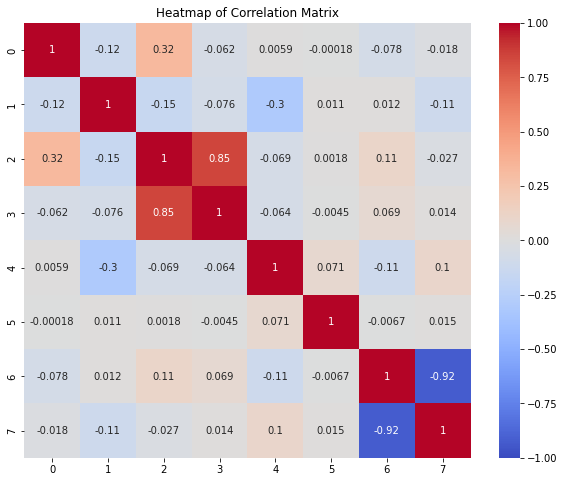

In [7]:
# リスト2のコードの後に以下を記述する

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練セットをpandas DataFrame化
X = pd.DataFrame(X_train)

# 相関行列の計算
corr_matrix = X.corr()

# 相関行列のヒートマップ図の表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

#### ●分散膨張係数（VIF）を用いる方法

In [8]:
# リスト2のコードの後に以下を記述する

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 訓練セットをpandas DataFrame化
X = pd.DataFrame(X_train)

# VIFの計算
vif_data = pd.DataFrame()
vif_data['Feature'] = housing.feature_names
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIFの結果を評価
print(vif_data)
#       Feature       VIF
# 0      MedInc  2.506234
# 1    HouseAge  1.247925
# 2    AveRooms  8.468261
# 3   AveBedrms  7.117997
# 4  Population  1.141382
# 5    AveOccup  1.007791
# 6    Latitude  9.325308
# 7   Longitude  8.999270

      Feature       VIF
0      MedInc  2.506234
1    HouseAge  1.247925
2    AveRooms  8.468261
3   AveBedrms  7.117997
4  Population  1.141382
5    AveOccup  1.007791
6    Latitude  9.325308
7   Longitude  8.999270


### 今回は、これで終わりです。お疲れさまでした。

---

### ■【参考】本稿に掲載した図版のコード

以下に、本稿で使用した図版を作成するためのコードを参考として掲載しています。記事の理解には必要ありませんが、興味がある方は参考にしてください。

図版で日本語を使用しているため、以下のインストールとインポートが必要です。

In [9]:
! pip install japanize-matplotlib

In [10]:
import japanize_matplotlib

#### 図3　線形回帰モデルの回帰直線の例

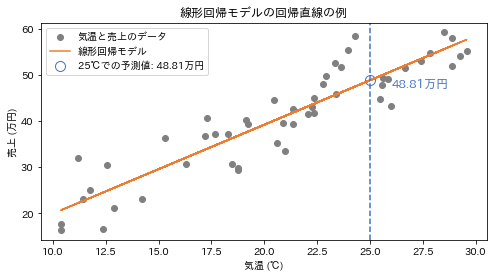

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 線形回帰モデルの直線
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 

# 25℃での売上予測
predicted_value = poly1d_fn(25)

# プロット
plt.figure(figsize=(8, 4))
plt.scatter(x, y, label='気温と売上のデータ', color='gray')
plt.plot(x, poly1d_fn(x), color='#ED7D31', label='線形回帰モデル')

# 25℃での予測点とライン
plt.axvline(x=25, color='#4472C4', linestyle='--')
plt.scatter([25], [predicted_value], color='white', edgecolor='#4472C4', s=100, label=f'25℃での予測値: {predicted_value:.2f}万円')
plt.text(25 + 1.0, predicted_value - 2, f'{predicted_value:.2f}万円', color='#4472C4', fontsize=12, verticalalignment='bottom')

plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('線形回帰モデルの回帰直線の例')
plt.legend()

plt.show()

#### 図4　単回帰モデルでの回帰直線の数式

<font color="#ED7D31">$$y = 0.73212 + 1.92318x$$</font>

$y = 0.73212 + 1.92318x$


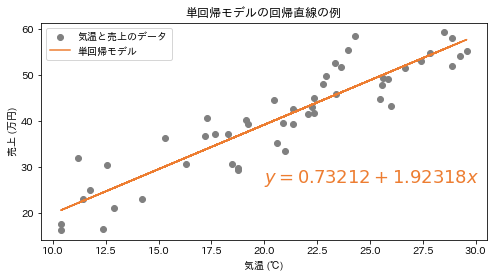

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 線形回帰モデルの直線
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 

# プロット
plt.figure(figsize=(8, 4))
plt.scatter(x, y, label='気温と売上のデータ', color='gray')
plt.plot(x, poly1d_fn(x), color='#ED7D31', label='単回帰モデル')

# 回帰直線の数式
equation_text = f'$y = {coef[1]:.5f} + {coef[0]:.5f}x$'
plt.text(20, 30, equation_text, color='#ED7D31', fontsize=18, fontweight='bold', verticalalignment='top')

plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('単回帰モデルの回帰直線の例')
plt.legend()

print(equation_text)
plt.show()

#### 図5　重回帰モデルでの回帰直線の数式

<font color="#ED7D31">$$ y = 1.40805 + 4.62026x_1 + 0.00536x_2 $$</font>

$y = 1.40805 + 4.62026x_1 + 0.00536x_2$


C:\Users\masa-i\AppData\Local\Temp\ipykernel_32668\2802956485.py:31: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  scatter = ax.scatter(num_rooms, building_age, rent_price, color='gray', label='各条件と賃貸価格のデータ')
C:\Users\masa-i\AppData\Local\Temp\ipykernel_32668\2802956485.py:34: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  surface = ax.plot_surface(xx, yy, zz, color='#ED7D31', alpha=0.4, rstride=100, cstride=100, edgecolor='none')
C:\Users\masa-i\AppData\Local\Temp\ipykernel_32668\2802956485.py:38: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  blue_circle = ax.scatter([3]

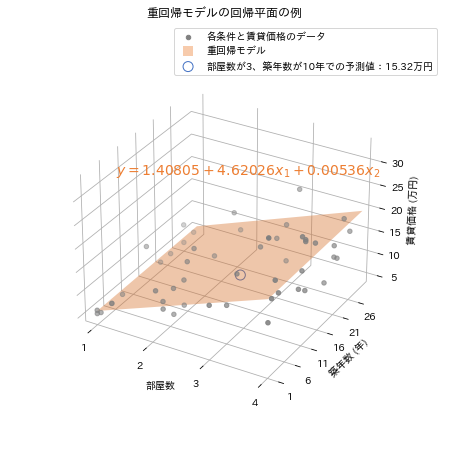

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 仮のデータ生成
np.random.seed(0)
num_rooms = np.random.randint(1, 5, 50)  # 部屋数（1～4部屋）
building_age = np.random.randint(1, 31, 50)  # 築年数（1～30年）
rent_price = 5 * num_rooms + 3 * (1 / building_age) + np.random.normal(0, 5, 50)  # 賃貸価格（万円）

# 賃貸価格を5万～50万に調整
rent_price = np.clip(rent_price, 5, 50)

# 特徴量とターゲットを整形
X = np.column_stack((num_rooms, building_age))
y = rent_price

# 線形回帰モデルの訓練
model = LinearRegression()
model.fit(X, y)

# 回帰平面の作成
xx, yy = np.meshgrid(np.linspace(1, 4, 10), np.linspace(1, 30, 10))
zz = model.intercept_ + model.coef_[0] * xx + model.coef_[1] * yy

# プロット
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# データ点のプロット
scatter = ax.scatter(num_rooms, building_age, rent_price, color='gray', label='各条件と賃貸価格のデータ')

# 回帰平面のプロット
surface = ax.plot_surface(xx, yy, zz, color='#ED7D31', alpha=0.4, rstride=100, cstride=100, edgecolor='none')

# 青い輪のプロット（部屋数が3、築年数が10年の位置）
predicted_price = model.predict(np.array([[3, 10]]))[0]
blue_circle = ax.scatter([3], [10], [predicted_price], facecolors='none', edgecolors='#4472C4', s=100, label=f'部屋数が3、築年数が10年での予測値：{predicted_price:.2f}万円')

# 回帰平面の数式
equation_text = f'$y = {model.intercept_:.5f} + {model.coef_[0]:.5f}x_1 + {model.coef_[1]:.5f}x_2$'
ax.text2D(0.25, 0.65, equation_text, transform=ax.transAxes, fontsize=14, color='#ED7D31')

# 軸ラベル
ax.set_xlabel('部屋数')
ax.set_ylabel('築年数 (年)')
ax.set_zlabel('賃貸価格 (万円)')
ax.set_title('重回帰モデルの回帰平面の例')

# 軸の目盛りを整数に設定
ax.set_xticks(np.arange(1, 5, 1))
ax.set_yticks(np.arange(1, 31, 5))

# 軸の背景を透明に設定し、軸の線を消す
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ボックスアスペクトの設定（ズーム）
ax.set_box_aspect(aspect=None, zoom=0.8)

# 視点の調整（下向きに回転）
ax.view_init(elev=30., azim=-60)

# 凡例の表示
handles, labels = ax.get_legend_handles_labels()

# 凡例の順序を設定
line_proxy = plt.Line2D([0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor='#ED7D31', alpha=0.4, markeredgewidth=0)
handles = [scatter, line_proxy, blue_circle]
labels = ['各条件と賃貸価格のデータ', '重回帰モデル', f'部屋数が3、築年数が10年での予測値：{predicted_price:.2f}万円']
ax.legend(handles=handles, labels=labels)

print(equation_text)
plt.show()

#### 図6　回帰モデルでの内挿と外挿

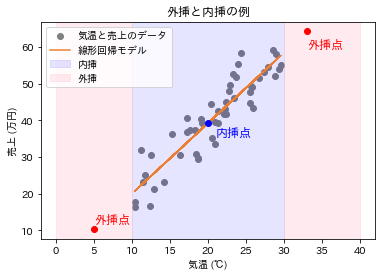

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 線形回帰モデルの直線
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 

# プロット
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='気温と売上のデータ', color='gray')
plt.plot(x, poly1d_fn(x), color='#ED7D31', label='線形回帰モデル')

# 内挿と外挿の領域を示す
plt.axvspan(10, 30, color='blue', alpha=0.1, label='内挿')
plt.axvspan(0, 10, color='pink', alpha=0.3, label='外挿')
plt.axvspan(30, 40, color='pink', alpha=0.3)

# 内挿と外挿の例を追加
plt.scatter([5, 33], [poly1d_fn(5), poly1d_fn(33)], color='red', zorder=5)
plt.text(5, poly1d_fn(5)+1, '外挿点', color='red', fontsize=12, verticalalignment='bottom')
plt.text(33, poly1d_fn(33)-5, '外挿点', color='red', fontsize=12, verticalalignment='bottom')

# 内挿点
plt.scatter([20], [poly1d_fn(20)], color='blue', zorder=5)
plt.text(20+1, poly1d_fn(20)-4, '内挿点', color='blue', fontsize=12, verticalalignment='bottom')

plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('外挿と内挿の例')
plt.legend()

plt.show()

#### 図7　仕組みの理解： 訓練セットをプロットした散布図

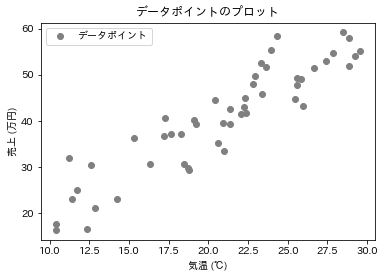

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# プロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('データポイントのプロット')
plt.legend()
plt.show()

#### 図8　仕組みの理解： 散布図上に描画した仮定の回帰直線

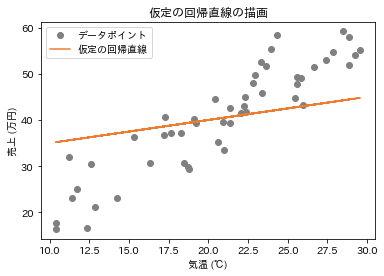

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 仮定の直線
initial_slope = 0.5
initial_intercept = 30.0
y_pred = initial_slope * x + initial_intercept

# プロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred, label='仮定の回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('仮定の回帰直線の描画')
plt.legend()
plt.show()

#### 図9　仕組みの理解： 各テータポイントと仮の回帰直線の残差

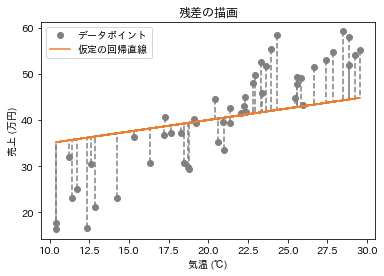

In [17]:
residuals = y - y_pred
residuals_squared = residuals ** 2

# 残差のプロット
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], y_pred[i]], color='gray', linestyle='--')

plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred, label='仮定の回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('残差の描画')
plt.legend()
plt.show()

$$
\begin{align}
\mathrm{RSS} &= \sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2} \\
&\color{gray}{= \sum_{i番目=1から}^{データ数まで総和}(観測値_{i番目}-予測値_{i番目　})^{2乗}}
\end{align}
$$

$$
\begin{align}
\mathrm{RSS} &= \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_i))^2 \\
&\color{gray}{= \sum_{i番目=1から}^{データ数まで総和}(観測値_{i番目} - (切片 + 傾き \times 特徴量_{i番目　}))^{2乗}}
\end{align}
$$


<a name="numsolve"></a>

#### 【数値的に解く】計算方法（非常に時間がかかるのでご注意ください）

In [18]:
import numpy as np

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# β0とβ1の範囲設定
beta0_values = np.arange(-100, 100, 0.01)
beta1_values = np.arange(0, 4, 0.01)

# 残差の二乗和 (RSS) を計算
min_rss = float('inf')
optimal_beta0 = None
optimal_beta1 = None
rss_values = []

for beta0 in beta0_values:
    for beta1 in beta1_values:
        rss = np.sum((y - (beta1 * x + beta0)) ** 2)
        rss_values.append({'beta0': beta0, 'beta1': beta1, 'rss': rss})
        if rss < min_rss:
            min_rss = rss
            optimal_beta0 = beta0
            optimal_beta1 = beta1

# 結果の出力
print(f'最適な切片 (β0): {optimal_beta0}')
print(f'最適な傾き (β1): {optimal_beta1}')
print(f'回帰直線の方程式: y = {optimal_beta0} + {optimal_beta1} * x')
# 最適な切片 (β0): 0.8000000000515683
# 最適な傾き (β1): 1.92
# 回帰直線の方程式: y = 0.8000000000515683 + 1.92 * x

最適な切片 (β0): 0.8000000000515683
最適な傾き (β1): 1.92
回帰直線の方程式: y = 0.8000000000515683 + 1.92 * x


<a name="rss3dgraph"></a>

#### 【数値的に解く】RSSが最小化する係数と切片の組み合わせを図示した3次元グラフ

C:\Users\masa-i\AppData\Local\Temp\ipykernel_32668\1327882601.py:31: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  surf = ax.plot_surface(beta0_mesh, beta1_mesh, rss_mesh, facecolors=colors, rstride=1, cstride=1, alpha=0.8, edgecolor='none')
C:\Users\masa-i\AppData\Local\Temp\ipykernel_32668\1327882601.py:32: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.scatter(optimal_beta0, optimal_beta1, min_rss, color='blue', s=100, label=f'最小RSS: β0 = {optimal_beta0:.2f}, β1 = {optimal_beta1:.2f}')


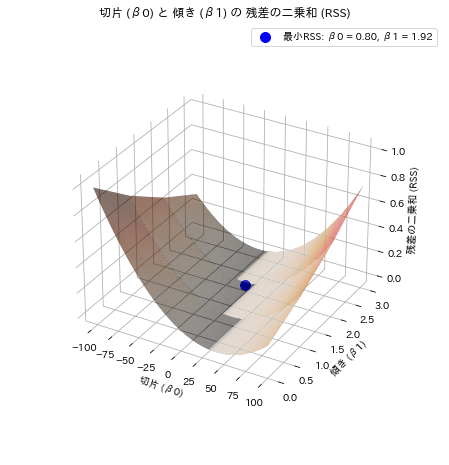

In [19]:
import numpy as np

# データを間引く
sampling_rate = 100  # 間引く割合を調整
rss_values_sampled = rss_values[::sampling_rate]

# β0とβ1とRSSを抽出
beta0_values = [entry['beta0'] for entry in rss_values_sampled]
beta1_values = [entry['beta1'] for entry in rss_values_sampled]
rss_values_for_plot = [entry['rss'] for entry in rss_values_sampled]

# メッシュグリッドの作成
beta0_mesh, beta1_mesh = np.meshgrid(np.unique(beta0_values), np.unique(beta1_values))
rss_mesh = np.zeros(beta0_mesh.shape)

for entry in rss_values_sampled:
    i = np.where(beta0_mesh[0] == entry['beta0'])[0][0]
    j = np.where(beta1_mesh[:, 0] == entry['beta1'])[0][0]
    rss_mesh[j, i] = entry['rss']

import matplotlib.pyplot as plt

# プロット
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# カラーマップの設定
colors = plt.cm.Oranges(rss_mesh / np.max(rss_mesh))

# 3Dプロット
surf = ax.plot_surface(beta0_mesh, beta1_mesh, rss_mesh, facecolors=colors, rstride=1, cstride=1, alpha=0.8, edgecolor='none')
ax.scatter(optimal_beta0, optimal_beta1, min_rss, color='blue', s=100, label=f'最小RSS: β0 = {optimal_beta0:.2f}, β1 = {optimal_beta1:.2f}')

# ラベルとタイトルの設定
ax.set_xlabel('切片 (β0)')
ax.set_ylabel('傾き (β1)')
ax.set_zlabel('残差の二乗和 (RSS)')
ax.set_title('切片 (β0) と 傾き (β1) の 残差の二乗和 (RSS)')

# 軸の背景を透明に設定し、軸の線を消す
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ボックスアスペクトの設定（ズーム）
ax.set_box_aspect(aspect=None, zoom=0.8)

# 視点の調整（下向きに回転）
ax.view_init(elev=30., azim=-60)

# 凡例の設定
ax.legend()

plt.show()

#### 図10　仕組みの理解： RSSが最小化する「切片」の値

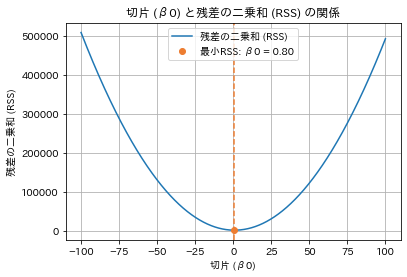

In [20]:
import matplotlib.pyplot as plt

# β0と対応するRSSを抽出
beta0_rss_values = [(entry['beta0'], entry['rss']) for entry in rss_values if entry['beta1'] == optimal_beta1]
beta0_values, rss_values_for_plot = zip(*beta0_rss_values)

# β1と対応するRSSを抽出
beta1_rss_values = [(entry['beta1'], entry['rss']) for entry in rss_values if entry['beta0'] == optimal_beta0]
beta1_values, rss_values_for_beta1_plot = zip(*beta1_rss_values)

# β0に対するRSSのプロット
plt.figure(figsize=(6, 4))
plt.plot(beta0_values, rss_values_for_plot, label='残差の二乗和 (RSS)')
plt.scatter(optimal_beta0, min_rss, color='#ED7D31', zorder=5, label=f'最小RSS: β0 = {optimal_beta0:.2f}')
plt.axvline(x=optimal_beta0, color='#ED7D31', linestyle='--')

plt.xlabel('切片 (β0)')
plt.ylabel('残差の二乗和 (RSS)')
plt.title('切片 (β0) と残差の二乗和 (RSS) の関係')
plt.legend()
plt.grid(True)

plt.show()

#### 図11　仕組みの理解： RSSが最小化する「気温に対する係数」の値

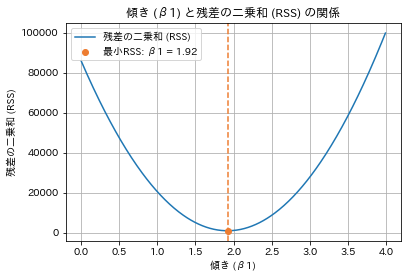

In [21]:
# β1に対するRSSのプロット
plt.figure(figsize=(6, 4))
plt.plot(beta1_values, rss_values_for_beta1_plot, label='残差の二乗和 (RSS)')
plt.scatter(optimal_beta1, min_rss, color='#ED7D31', zorder=5, label=f'最小RSS: β1 = {optimal_beta1:.2f}')
plt.axvline(x=optimal_beta1, color='#ED7D31', linestyle='--')

plt.xlabel('傾き (β1)')
plt.ylabel('残差の二乗和 (RSS)')
plt.title('傾き (β1) と残差の二乗和 (RSS) の関係')
plt.legend()
plt.grid(True)

plt.show()

#### 図12　仕組みの理解： 散布図上に描画した最適な回帰直線

<font color="#ED7D31">$$ y= 0.80 + 1.92x $$</font>

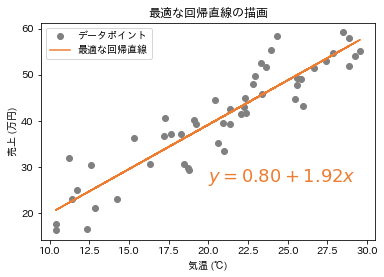

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 最適な傾きと切片の取得
beta_0_optimal = optimal_beta0  # 0.8
beta_1_optimal = optimal_beta1  # 1.92

# 最適な回帰直線に基づいて予測された y 値を計算
y_pred_optimal = beta_0_optimal + beta_1_optimal * x

# 回帰直線の数式
equation_text = f'$y = {beta_0_optimal:.2f} + {beta_1_optimal:.2f}x$'
plt.text(20, 30, equation_text, color='#ED7D31', fontsize=18, fontweight='bold', verticalalignment='top')

# プロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred_optimal, label='最適な回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('最適な回帰直線の描画')
plt.legend()
plt.show()

このように「数値的に解いた図12」と、以下のように「解析的に解いた図13」はほぼ同じになります。

<a name="analsolve"></a>

#### 図13　仕組みの理解： 解析的に解いた場合の回帰直線

<font color="#ED7D31">$$ y= 0.73 + 1.92x $$</font>

##### 【解析的に解く】ライブラリーを使わずに手書きで計算した場合

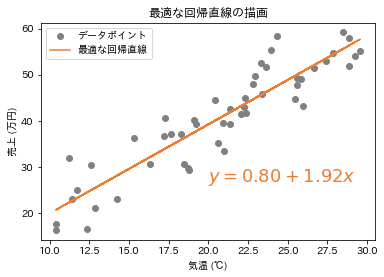

In [23]:
import numpy as np

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 平均を計算
x_mean = np.mean(x)  # xの平均
y_mean = np.mean(y)  # yの平均

# 切片（beta_0）の計算
# 切片の最適値 beta_0 の計算
beta_0_optimal = y_mean - beta_1_optimal * x_mean

# 傾き（beta_1）の計算
# 分子：共分散の計算
numerator = np.sum((x - x_mean) * (y - y_mean))
# 分母：xの分散の計算
denominator = np.sum((x - x_mean) ** 2)
# 傾きの最適値 beta_1 の計算
beta_1_optimal = numerator / denominator

# 最適な回帰直線に基づいて予測された y 値を計算
y_pred_optimal = beta_0_optimal + beta_1_optimal * x

# 回帰直線の数式
equation_text = f'$y = {beta_0_optimal:.2f} + {beta_1_optimal:.2f}x$'
plt.text(20, 30, equation_text, color='#ED7D31', fontsize=18, fontweight='bold', verticalalignment='top')

# 最適な直線のプロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred_optimal, label='最適な回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('最適な回帰直線の描画')
plt.legend()
plt.show()

##### 【解析的に解く】scikit-learnを使って計算した場合

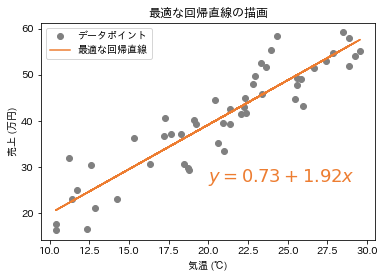

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 線形回帰モデルの作成（scikit-learnを使用）
model = LinearRegression()
x_reshaped = x.reshape(-1, 1)
model.fit(x_reshaped, y)

# 最適な傾きと切片の取得
beta_0_optimal = model.intercept_
beta_1_optimal = model.coef_[0]

# 最適な回帰直線に基づいて予測された y 値を計算
y_pred_optimal = beta_0_optimal + beta_1_optimal * x

# 回帰直線の数式
equation_text = f'$y = {beta_0_optimal:.2f} + {beta_1_optimal:.2f}x$'
plt.text(20, 30, equation_text, color='#ED7D31', fontsize=18, fontweight='bold', verticalalignment='top')

# 最適な直線のプロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred_optimal, label='最適な回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('最適な回帰直線の描画')
plt.legend()
plt.show()

##### 【解析的に解く】NumPyのpolyfit関数を使って計算した場合

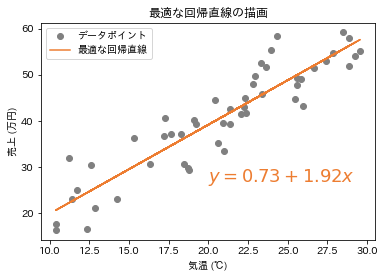

In [25]:
import numpy as np

# 仮のデータ生成
np.random.seed(0)
x = np.random.uniform(10, 30, 50)
y = 2 * x + np.random.normal(0, 5, 50)

# 線形回帰モデルの作成（NumPyのpolyfit関数を使用）
coef = np.polyfit(x, y, 1)

# 最適な傾きと切片の取得
beta_0_optimal = coef[1]  # 切片
beta_1_optimal = coef[0]  # 傾き

# 最適な回帰直線に基づいて予測された y 値を計算
y_pred_optimal = beta_0_optimal + beta_1_optimal * x

# 回帰直線の数式
equation_text = f'$y = {beta_0_optimal:.2f} + {beta_1_optimal:.2f}x$'
plt.text(20, 30, equation_text, color='#ED7D31', fontsize=18, fontweight='bold', verticalalignment='top')

# 最適な直線のプロット
plt.scatter(x, y, label='データポイント', color='gray')
plt.plot(x, y_pred_optimal, label='最適な回帰直線', color='#ED7D31')
plt.xlabel('気温 (℃)')
plt.ylabel('売上 (万円)')
plt.title('最適な回帰直線の描画')
plt.legend()
plt.show()